In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv


In [2]:
train = pd.read_csv("../input/playground-series-s3e8/train.csv").drop(columns='id')
test = pd.read_csv("../input/playground-series-s3e8/test.csv").drop(columns='id')


In [3]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [4]:
summary(train)

data shape: (193573, 10)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
carat,float64,0,0.0,248,0.2,3.5,1.52,2.03,0.7
cut,object,0,0.0,5,NaN,NaN,Premium,Very Good,Ideal
color,object,0,0.0,7,NaN,NaN,F,J,G
clarity,object,0,0.0,8,NaN,NaN,VS2,SI2,VS1
depth,float64,0,0.0,153,52.1,71.6,62.2,62.0,61.2
table,float64,0,0.0,108,49.0,79.0,58.0,58.0,57.0
x,float64,0,0.0,522,0.0,9.65,7.27,8.06,5.69
y,float64,0,0.0,521,0.0,10.01,7.33,8.12,5.73
z,float64,0,0.0,349,0.0,31.3,4.55,5.05,3.5
price,int64,0,0.0,8738,326.0,18818.0,13619,13387,2772


In [5]:
num_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
all_cols = num_cols + cat_cols

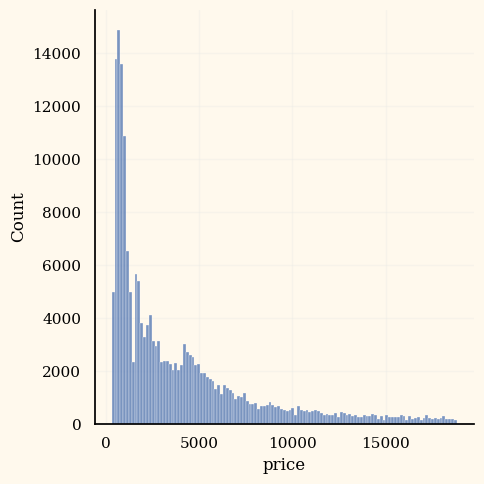

In [6]:
sns.displot(train, x="price")

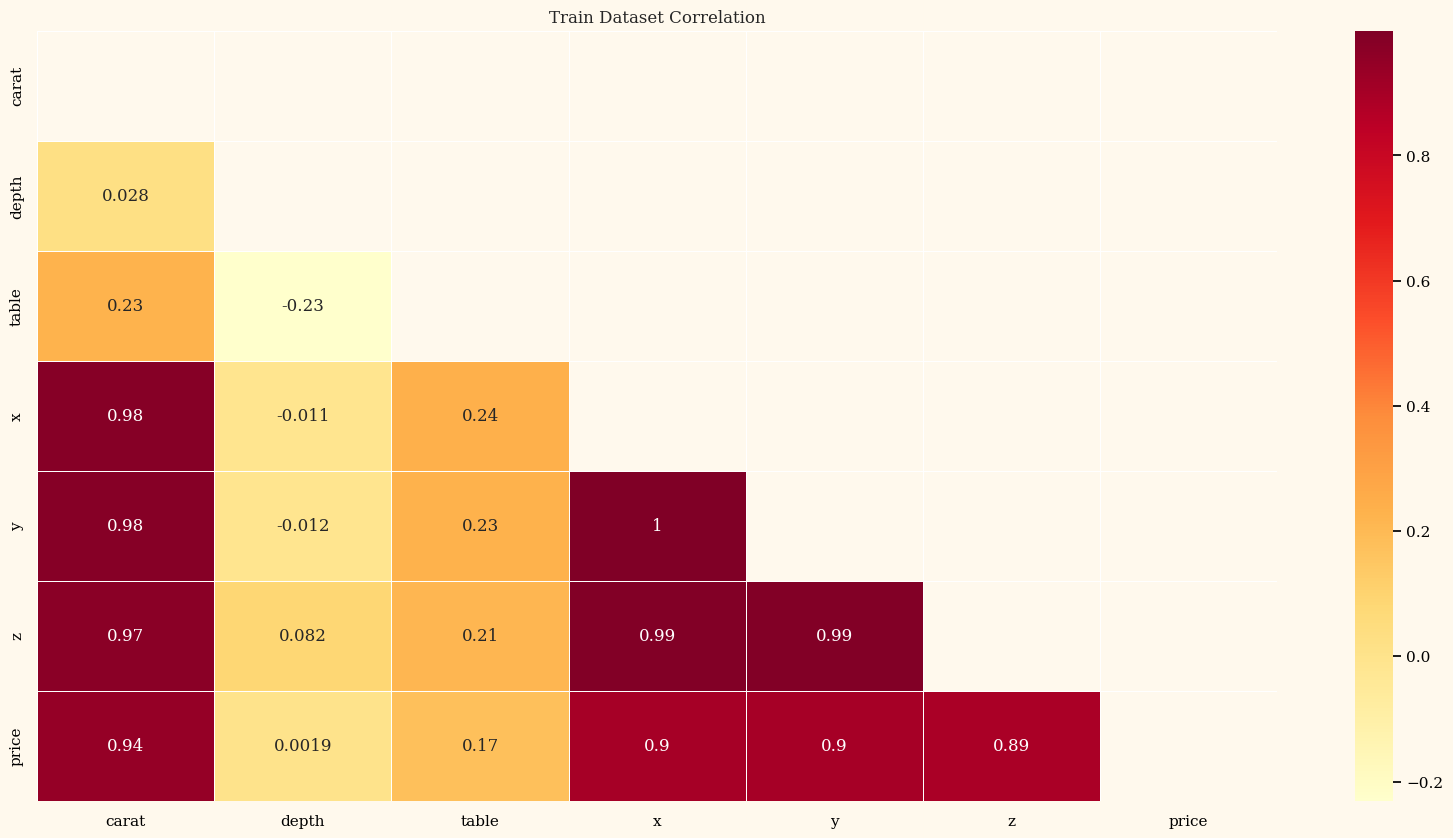

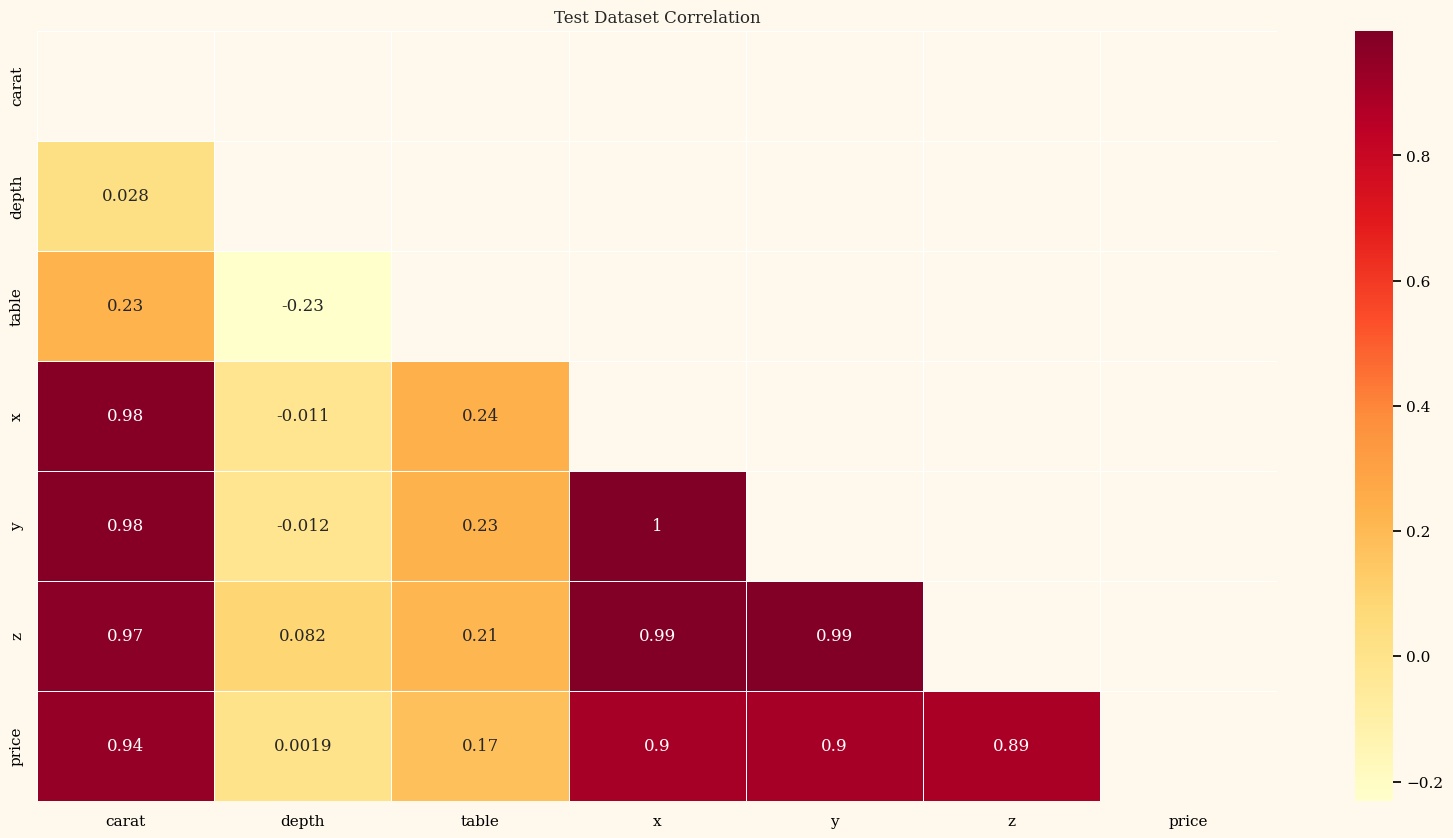

In [7]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(train, 'Test Dataset Correlation')

In [8]:
train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [9]:
df = train

In [10]:
print( f'data shape of train dataset:' ,train.shape)

data shape of train dataset: (193573, 10)


In [11]:
dummies = pd.get_dummies(df[['cut', 'color', 'clarity']])
X = df.drop(columns = ['cut', 'color', 'clarity', 'price'], axis = 1)
X = pd.concat([X, dummies], axis = 1)
Y = df['price']

In [12]:
dummies_test = pd.get_dummies(test[['cut', 'color', 'clarity']])
test = pd.concat([test.drop(columns = ['cut', 'color', 'clarity'], axis = 1), dummies_test], axis = 1)

In [13]:

from sklearn.metrics import mean_squared_error

cv_scores = list()
importance_xgb = list()
preds = list()


for i in range(3):
    print(f'{i} fold cv begin')
    skf = KFold(n_splits = 3, random_state = 1004, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.8, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 8, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.8).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test)
        
  
        cv_scores.append(mean_squared_error(Y_test, XGB_pred_1, squared = False))
        preds.append(XGB_pred_2)
        print(f'{i} fold cv done')

scores = np.mean(cv_scores)    
print('The average RMSE over 3-folds (run 3 times) is:', scores)

0 fold cv begin
0 fold cv done
0 fold cv done
0 fold cv done
1 fold cv begin
1 fold cv done
1 fold cv done
1 fold cv done
2 fold cv begin
2 fold cv done
2 fold cv done
2 fold cv done
The average RMSE over 3-folds (run 3 times) is: 576.4907687411448


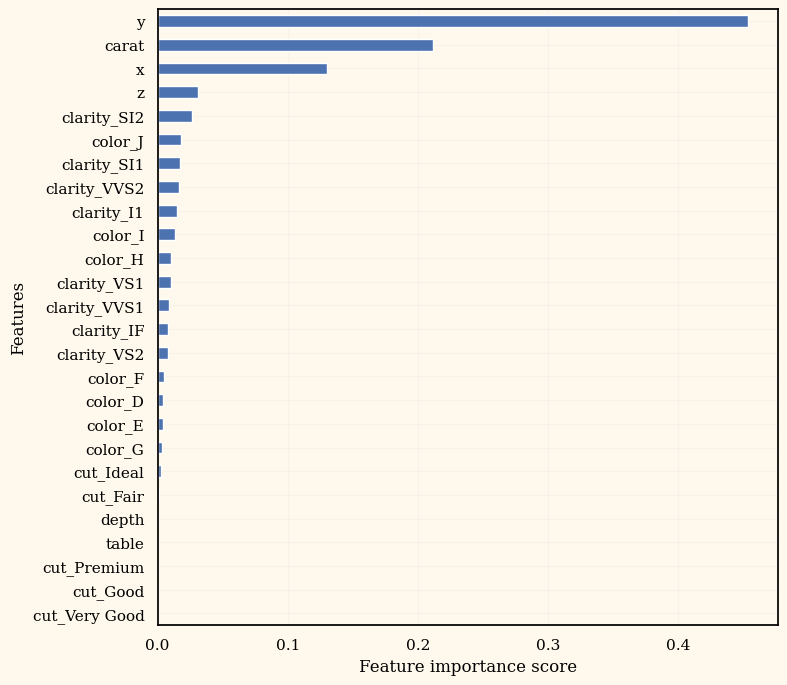

In [14]:
plt.figure(figsize = (8, 8))
pd.DataFrame(importance_xgb, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('Feature importance score')
plt.ylabel('Features')
plt.show(); 

In [15]:
preds_mean_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
test_submit = pd.read_csv("../input/playground-series-s3e8/test.csv", usecols = ['id'])
test_submit['price'] = preds_mean_test
test_submit.head()

,id,price
0,193573,879.118469
1,193574,2498.056885
2,193575,2334.111084
3,193576,825.650269
4,193577,5763.517090


In [16]:
test_submit.to_csv('submission.csv', index = False)